In [1]:
import os

from matplotlib import pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
import seaborn as sns
import simdna
from simdna import synthetic
import statsmodels.api as sm
import torch
from tqdm.auto import tqdm

from utils import one_hot_decode
from in_silico_mutagenesis import compute_summary_statistics, generate_wt_mut_batches, write_results
from pyx.one_hot import one_hot
from tf_coop_model import CountsRegressor, IterablePandasDataset
from tf_coop_model import anscombe_transform, run_one_epoch, spearman_rho, pearson_r
from tf_coop_simulation import background_frequency
from tf_coop_simulation import simulate_counts, simulate_oracle_predictions

In [2]:
%load_ext autoreload
%autoreload 2

/home/stephenmalina/anaconda3/envs/deepmr/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
np.random.seed(42)

# Initialize Model & Load Weights
This step assumes we've trained a counts regression model and have its weights stored in a .pt[h] file somewhere accessible.

In [23]:
n_conv_layers = 3
n_dense_layers = 3
n_outputs = 2
sequence_length = 100
filters = 15
filter_width = 7
dense_layer_width = 30

weights_dir = '../dat/sim/'
weights_fname = 'cnn_counts_predictor_with_variants.pt'
test_data_fpath = '../dat/sim/test_labels.csv'
raw_simulation_data_fpath = '../dat/sim/test_sequences.simdata'
mutagenesis_results_dir = '../dat/sim/res/'

os.makedirs(mutagenesis_results_dir, exist_ok=True)

sequences_col = "sequences"
label_cols = ["labels_exp", "labels_out"]
batch_size = 1000
n_samples = 10

exposure_motif = "GATA_disc1"
outcome_motif = "TAL1_known1"

In [5]:
torch.set_grad_enabled(False)

In [6]:
class Ensemble:
    def __init__(self, model_base_dir, model_fname, model_params, n_reps=5):
        models = []
        for i in range(1, n_reps+1):
            model = CountsRegressor(**params)
            model.load_state_dict(torch.load(os.path.join(model_base_dir, str(i), model_fname)))
            models.append(model)
        self.models = models

    def predict(self, seqs, targets=None):
        preds = {}
        for model in self.models:
            model_preds = model(seqs, targets=targets)
            for key, preds_ in model_preds.items():
                preds.setdefault(key, []).append(preds_.detach().cpu().numpy())
        return {k: np.stack(v) for k, v in preds.items()}

In [7]:
params = {
    "n_conv_layers": n_conv_layers,
    "n_dense_layers": n_dense_layers,
    "n_outputs": n_outputs,
    "sequence_length": sequence_length,
    "filters": filters,
    "filter_width": filter_width,
    "dense_layer_width": dense_layer_width
}
ensemble_model = Ensemble(weights_dir, "cnn_counts_predictor_with_variants.pt", params)
ensemble_model

# Load Test Data & Generate Predictions
Now we're going to load test data to get some basic metrics about how well our model performs.

In [8]:
test_df = pd.read_csv(test_data_fpath)
test_dataset = IterablePandasDataset(
    test_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, num_workers=0
)

# Running Deep MR
In Shrikumar et al, all effects are computed in raw counts space. Here, for purposes of making our result relevant to Deep MR, we compute interaction effects in both Anscombe-transformed space and raw counts space but focus on the validity of the former.

In [15]:
both_motifs_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 1)]
exposure_motif_df = test_df[(test_df['has_exposure'] == 1) & (test_df['has_outcome'] == 0)]
outcome_motif_df = test_df[(test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 1)]
neither_motif_df = test_df[
    (test_df['has_exposure'] == 0) & (test_df['has_outcome'] == 0)
]

In [16]:
len(both_motifs_df), len(exposure_motif_df), len(outcome_motif_df), len(neither_motif_df)

(2499, 2514, 2460, 2527)

In [17]:
both_motifs_dataset = IterablePandasDataset(
    both_motifs_df, x_cols=sequences_col, y_cols=label_cols, x_transform=one_hot,
)
both_motifs_data_loader = torch.utils.data.DataLoader(
    both_motifs_dataset, batch_size=batch_size, num_workers=0
)

In [18]:
def mutate_and_predict(model, sample_dataset):
    preds = {}
    all_muts = []
    for seq, label in tqdm(sample_dataset):
        muts = generate_wt_mut_batches(seq, seq.shape[0] * seq.shape[1]).squeeze()
        muts = muts.transpose(0, 1, 2)
        muts = torch.from_numpy(muts)
        label = torch.from_numpy(label)
        preds_ = model.predict(muts, targets=label)['predictions']
        exposure_preds = preds_[:, :, 0]
        outcome_preds = preds_[:, :, 1]
        preds.setdefault('exposure', []).append(exposure_preds)
        preds.setdefault('outcome', []).append(outcome_preds)
        all_muts.append(muts.detach().cpu().numpy())
    return all_muts, preds

In [19]:
# both_motifs_sample_dataset, _ = torch.utils.data.random_split(
#     both_motifs_dataset, (n_samples, len(both_motifs_dataset) - n_samples)
# )
both_motifs_sample_dataset = both_motifs_dataset

In [21]:
muts, preds = mutate_and_predict(ensemble_model, both_motifs_dataset)
sample_seqs = [seq for seq, label in both_motifs_dataset]

In [25]:
exposure_col = "exposure"
outcome_col = "outcome"

formatted_preds = np.stack((preds[exposure_col], preds[outcome_col]))
n_features, n_seqs, n_reps, n_variants = formatted_preds.shape
formatted_preds = formatted_preds.transpose(2, 1, 3, 0)
formatted_preds = formatted_preds.reshape(n_reps, n_seqs, 4, -1, n_features)

means, mean_diffs, stderrs = compute_summary_statistics(formatted_preds, np.array(sample_seqs))

np.save(os.path.join(mutagenesis_results_dir, "GATA_TAL1_means_v4.npy"), means)
np.save(os.path.join(mutagenesis_results_dir, "GATA_TAL1_stderrs_v4.npy"), stderrs)

results_fname = f'GATA_TAL1_effect_sizes_v4.csv'
results_fpath = os.path.join(mutagenesis_results_dir, results_fname)
write_results(results_fpath, mean_diffs, stderrs)

/home/stephenmalina/dev/an1lam/deepmr/src/in_silico_mutagenesis.py:168: RuntimeWarning: invalid value encountered in sqrt
  stderrs = np.sqrt(ref_vars + mut_vars - 2 * covs)


In [26]:
seq_cis = []
for i in range(len(sample_seqs)):
    x = sm.add_constant(mean_diffs[i, :, :, 0].flatten(), prepend=False)
    y = mean_diffs[i, :, :, 1].flatten()
    ols_res = sm.OLS(y, x).fit()
    seq_cis.append(ols_res.params[0])

In [27]:
seq_cis[:10]

[0.849177206862372,
 0.8944697620453014,
 0.9758140317586259,
 0.7846855512616776,
 0.9090124179972853,
 0.9896933286667877,
 0.970583925481687,
 0.8725114526625535,
 0.9087026518659995,
 -4.616994764875324]

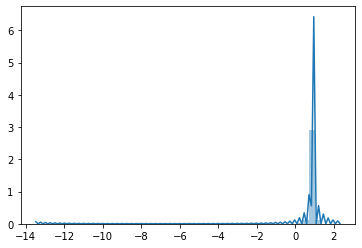

In [29]:
sns.distplot(seq_cis)

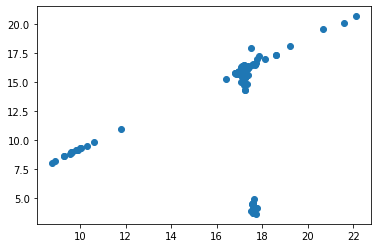

In [28]:
plt.scatter(means[0, :, :, 0], means[0, :, :, 1])

In [ ]:
plt.scatter()